In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [14]:
# ============================
# CONFIGURATION
# ============================
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3


PUBLIC_PREP_DIR = "../preprocessed_Public"
SELF_PREP_DIR = "../Dataset"

In [15]:
# ============================
# DATA GENERATORS
# ============================


# Training & validation generator (public dataset)
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input
)


val_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input
)


train_gen = train_datagen.flow_from_directory(
os.path.join(PUBLIC_PREP_DIR, "train"),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical'
)


val_gen = val_datagen.flow_from_directory(
os.path.join(PUBLIC_PREP_DIR, "val"),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical'
)


# Test generator (self-collected dataset)
test_gen = val_datagen.flow_from_directory(
os.path.join(SELF_PREP_DIR),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical',
shuffle=False
)


print("✅ Data generators ready")

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.
✅ Data generators ready


In [16]:
# ============================
# MODEL ARCHITECTURE
# ============================


# Load MobileNetV3-Large backbone
base_model = MobileNetV3Large(
input_shape=(IMG_SIZE, IMG_SIZE, 3),
include_top=False,
weights='imagenet'
)


# Freeze backbone for transfer learning
base_model.trainable = False


# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=outputs)


print("✅ MobileNetV3-Large model built")
model.summary()

✅ MobileNetV3-Large model built


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,243,139 (12.37 MB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [17]:
# ============================
# COMPILE MODEL
# ============================


model.compile(
optimizer=Adam(learning_rate=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print("✅ Model compiled")

✅ Model compiled


In [18]:
# ============================
# CALLBACKS
# ============================


early_stop = EarlyStopping(
monitor='val_loss',
patience=5,
restore_best_weights=True,
verbose=1
)


reduce_lr = ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=3,
min_lr=1e-6,
verbose=1
)

In [19]:
# ============================
# TRAINING
# ============================


print("🚀 Starting MobileNetV3-Large training...\n")


history = model.fit(
train_gen,
epochs=EPOCHS,
validation_data=val_gen,
callbacks=[early_stop, reduce_lr],
verbose=1
)


print("✅ Training completed")

🚀 Starting MobileNetV3-Large training...

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.7323 - loss: 0.6520 - precision: 0.7595 - recall: 0.6983 - val_accuracy: 0.8759 - val_loss: 0.3062 - val_precision: 0.8923 - val_recall: 0.8635 - learning_rate: 1.0000e-04
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8872 - loss: 0.2935 - precision: 0.9029 - recall: 0.8731 - val_accuracy: 0.9032 - val_loss: 0.2586 - val_precision: 0.9112 - val_recall: 0.8908 - learning_rate: 1.0000e-04
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9161 - loss: 0.2159 - precision: 0.9260 - recall: 0.9068 - val_accuracy: 0.9132 - val_loss: 0.2365 - val_precision: 0.9241 - val_recall: 0.9057 - learning_rate: 1.0000e-04
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9358 - loss: 0.1744 - precision: 0.9438 - recall: 0.9294 - val_accuracy: 0.9156 - val_loss: 0.2280 - val_precision: 0.9293 - val_recall: 0.9132 - learning_rate: 1.0000e-04



📊 Evaluating on SELF-COLLECTED dataset...
Test Accuracy: 71.67%
Test Precision: 71.59%
Test Recall: 70.92%
Test F1-score: 71.25%
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 414ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.68      0.76      0.72       148
       paper       0.71      0.64      0.67       151
     plastic       0.74      0.74      0.74       234

    accuracy                           0.72       533
   macro avg       0.71      0.71      0.71       533
weighted avg       0.72      0.72      0.72       533



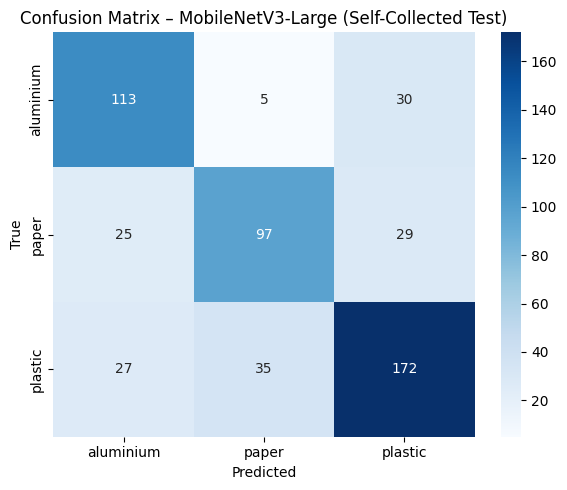

✅ Evaluation completed


In [23]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – MobileNetV3-Large (Self-Collected Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


print("✅ Evaluation completed")

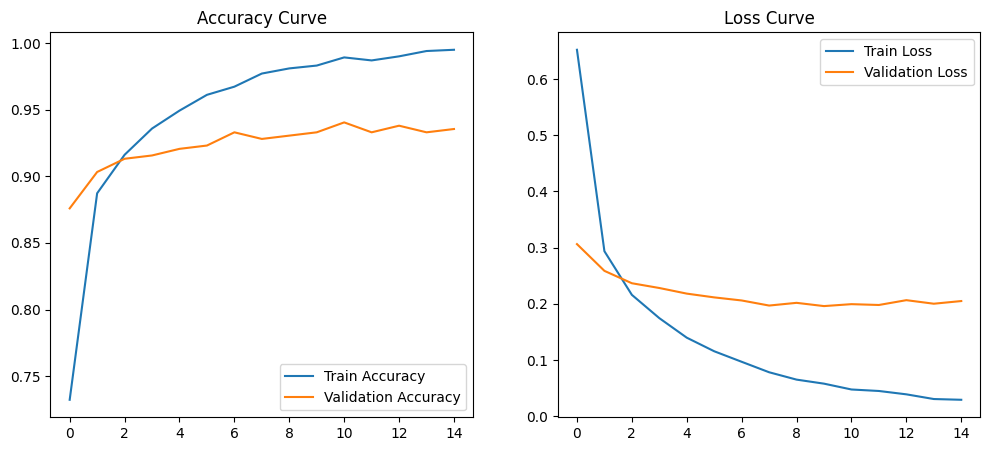

In [22]:
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()